In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
#elastic net
from sklearn import linear_model

In [2]:
def plot_regression_results(ax, y_true, y_pred, title,scores):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
#    ax.set_xlim([y_true.min(), y_true.max()])
#    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('NEMD CoF')
    ax.set_ylabel('Predicted CoF')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='best')
#    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

In [3]:
def plot_LASSO_pie(featuredict,cutoff):
    #separate postive and negative coefficients
    pos_f={}
    neg_f={}
    for feat in featuredict.keys():
        if featuredict[feat] < -cutoff:
            neg_f.update({feat:featuredict[feat]})
        if featuredict[feat] > cutoff:
            pos_f.update({feat:featuredict[feat]})
    #normalize the coefficients based on the size features
    neg_f_sum=np.sum(list(neg_f.values()))
    pos_f_sum=np.sum(list(pos_f.values()))
    for feat in pos_f.keys():
        pos_f[feat] = pos_f[feat]/pos_f_sum*len(pos_f)
    for feat in neg_f.keys():
        neg_f[feat] = neg_f[feat]/neg_f_sum*len(neg_f)
    #plot pie chart
    #define colors
    def make_rgb_transparent(rgb, bg_rgb, alpha):
        return [alpha * c1 + (1 - alpha) * c2
                for (c1, c2) in zip(rgb, bg_rgb)]
    red = np.divide([float(255), float(0), float(0)],float(255))
    orange = np.divide([float(255), float(165), float(0)],float(255))
    green = np.divide([float(0), float(196), float(64)],float(255))
    blue = np.divide([float(0), float(0), float(255)],float(255))
    gray = np.divide([float(140), float(140), float(140)],float(255))
    white = [1, 1, 1]
    first_colors = [blue, red]
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = 'positive','negative'
    sizes = [len(pos_f)/(len(featuredict))*100,len(neg_f)/(len(featuredict))*100]
    sub_sizes = list(pos_f.values())+list(neg_f.values())
    sub_labels = list(pos_f.keys())+list(neg_f.keys())
    colorlist =[]
    for i in list(pos_f.values()):
        colorlist.append(make_rgb_transparent(blue,white,i/len(pos_f)))
    for i in list(neg_f.values()):
        colorlist.append(make_rgb_transparent(red,white,i/len(neg_f)))
    #explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    #ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',colors=first_colors,
    #        shadow=True, startangle=90,)
    ax1.pie(sizes,labels=labels,colors=first_colors,startangle=90,radius=1.3,
            textprops={'fontsize': 50,'color':'black'},
        wedgeprops={"edgecolor":"1",'linewidth': 3,
                    'linestyle': 'solid', 'antialiased': True})
    ax1.pie(sub_sizes,labels=sub_labels,startangle=90,labeldistance=0.8,colors=colorlist,radius=1.3-0.3,
            textprops={'fontsize': 50,'color':'black'},
       wedgeprops={"edgecolor":"1",'linewidth': 3,
                    'linestyle': 'solid', 'antialiased': True})
    #plt.setp( ax1, width=0.3, edgecolor='white')
    plt.tight_layout()
#    plt.show()

Optimal regularization parameter : 2.5514065200312875e-05
Spearman correlation for 120C 0.5ms low: 0.8221388367729832 7.794161210153887e-11


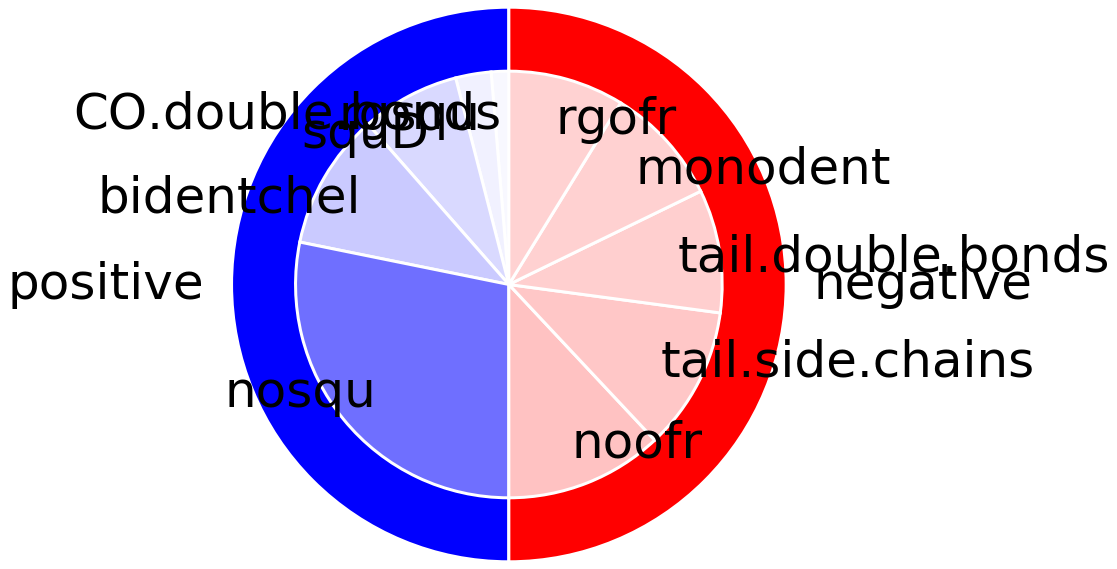

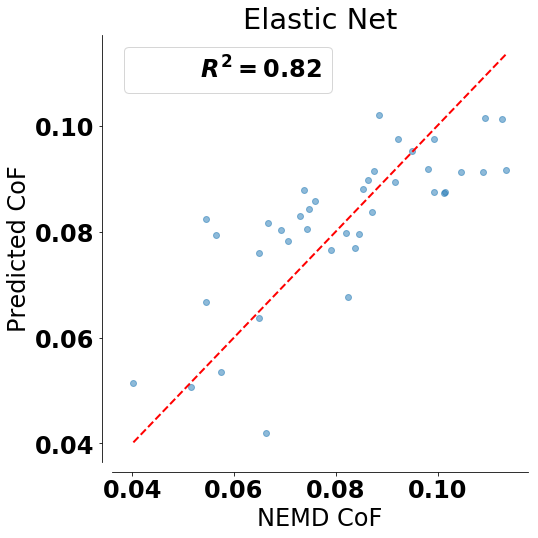

In [18]:
#temp=45
#sp=0.5
#cov='med'  
for temp in [120]:#, 120,150]:
    for sp in [0.5]:#, 1, 10]:
        for cov in ['low']:
            features = pd.read_excel('physprops-noRACs1.xlsx')
            
            features=features.loc[(features['temp']==temp)]
            features=features.loc[features['speed']==sp]
            features=features.loc[features[cov+'.cov']==1]
            
            # Labels are the values we want to predict
            labels = np.array(features['cof'])

            # Remove the labels from the features
            # axis 1 refers to the columns
            features= features.drop(['OFR','cof','speed','temp','thigh','tmed','tlow',
                         'vhigh','vmed','vlow','low.cov','med.cov',
                        'dens_max_top','dens_max_bot','dens_max_squ',
                        'Hz','ofr_bound_z','ofrgap',
                         'noofrtop','noofrbot'], axis = 1)
                        #,'dens_max_top',
                        #'dens_max_bot','dens_max_squ','CO.double.bonds',
                        # 'tail.double.bonds','tail.side.chains',
                        # 'rgofr','noofrbot','nosqu','noofrtop','ofrD','num.atoms',
                        #'bidentbr','bidentchel','monodent'], axis = 1) #'Hz','ofrgap','ofr_bound_z','rgsqu','squD'

            # Saving feature names for later use
            feature_list = list(features.columns)

            # Convert to numpy array
            features = np.array(features)
            # Split the data into training and testing sets
            train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3,
                                                                           random_state = 42)
            #Elastic Net fitting
            alphas = np.logspace(-5, 1, 60)
            enet = linear_model.ElasticNet(l1_ratio=0.5, max_iter=100000000)
            train_errors = list()
            test_errors = list()
            for alpha in alphas:
                enet.set_params(alpha=alpha)
                enet.fit(train_features, train_labels)
                train_errors.append(enet.score(train_features, train_labels))
                test_errors.append(enet.score(test_features, test_labels))

            i_alpha_optim = np.argmax(test_errors)
            alpha_optim = alphas[i_alpha_optim]
            print("Optimal regularization parameter : %s" % alpha_optim)

            # Estimate the coef_ on full data with optimal regularization parameter
            enet.set_params(alpha=alpha_optim)
            coef = enet.fit(features, labels).predict(test_features)

            plt.plot(labels,'ro')
            plt.plot(coef,'b')

            score, test_p = spearmanr(test_labels,coef)
            print('Spearman correlation for '+str(temp)+'C '+str(sp)+'ms '+cov+': '+ str(score) +' '+str(test_p))
            
            plt.subplot(2, 1, 1)
            plt.semilogx(alphas, train_errors, label='Train')
            plt.semilogx(alphas, test_errors, label='Test')
            plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=5, label='Optimum on test')
            plt.legend(loc='lower left')
            plt.ylim([0, 0.3])
            plt.xlabel('Regularization parameter')
            plt.ylabel('Performance')

            # Show estimated coef_ vs true coef
            plt.subplot(2, 1, 2)
            plt.plot(labels, label='True coef',linewidth=5)
            plt.plot(coef, label='Estimated coef',marker='o',linestyle='None',markerfacecolor='red',markersize=8)
            plt.legend()
            plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.26)
            #plt.show()
            plt.savefig('eln-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.png', dpi=None, facecolor='w', edgecolor='w',
            #plt.savefig('test.png', dpi=None, facecolor='w', edgecolor='w',
                    orientation='portrait', papertype=None, format=None,
                    transparent=False, bbox_inches=None, pad_inches=0.1,
                    frameon=None, metadata=None)
            plt.close('all')
            # Feature selection
            lfeatures=enet.coef_[enet.coef_ != 0]
            reserved_feats = []

            for i,c in enumerate((enet.coef_ != 0).ravel().tolist()):
                if c:
                    reserved_feats.append(feature_list[i])
            # Plot pie chart       
            fpairs = {}
            for i,f in enumerate(reserved_feats):
                fpairs.update({f:lfeatures[i]})
            featuredict = fpairs
            fpairs = sorted(fpairs.items(), key=lambda x: x[1])
            featuredict1 = {}
            for i,f in enumerate(reserved_feats):
                featuredict1.update({fpairs[i][0]:fpairs[i][1]})

            plot_LASSO_pie(featuredict1,0.001)
            plt.savefig('eln_coef_pie'+str(temp)+'-'+str(sp)+'ms'+cov+'.svg', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=False, bbox_inches='tight', pad_inches=0.1,
        frameon=None, metadata=None)
            plt.rc('font', size=24)
            plt.rcParams["figure.figsize"] = (8,8)
            plt.rc('font',family='sans-serif')
            plt.rcParams['font.sans-serif']
            plt.rc('font',weight='bold')
            fig, axs = plt.subplots()
            plot_regression_results(
                axs, test_labels, coef,
                "Elastic Net",('$R^2={:.2f}$').format(score))
            plt.tight_layout()
            plt.savefig('eln-parity-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.svg', dpi=None, facecolor='w', edgecolor='w',
#plt.savefig('test.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [5]:
features = pd.read_excel('physprops-noRACs.xlsx')
temp=45
sp=0.5
cov='med'
features=features.loc[(features['temp']==temp)]
features=features.loc[features['speed']==sp]
features=features.loc[features[cov+'.cov']==1]

In [6]:
# Labels are the values we want to predict
labels = np.array(features['cof'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop(['OFR','cof','speed','temp','thigh','tmed','tlow',
                         'vhigh','vmed','vlow','low.cov','med.cov',
                        'dens_max_top','dens_max_bot','dens_max_squ',
                        'Hz','ofr_bound_z','ofrgap','TPSA','LabuteASA',
                         'noofrtop','noofrbot','heavy.atom.wt'], axis = 1)
                        #,'dens_max_top',
                        #'dens_max_bot','dens_max_squ','CO.double.bonds',
                        # 'tail.double.bonds','tail.side.chains',
                        # 'rgofr','noofrbot','nosqu','noofrtop','ofrD','num.atoms',
                        #'bidentbr','bidentchel','monodent'], axis = 1) #'Hz','ofrgap','ofr_bound_z','rgsqu','squD'

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [7]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3,
                                                                           random_state = 42)

Optimal regularization parameter : 5.1506780761681216e-05


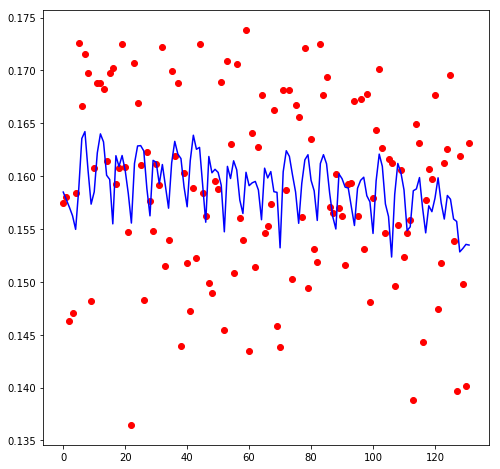

In [8]:
#elastic net
from sklearn import linear_model
alphas = np.logspace(-5, 1, 60)
enet = linear_model.ElasticNet(l1_ratio=0.5, max_iter=1000000)
train_errors = list()
test_errors = list()
for alpha in alphas:
    enet.set_params(alpha=alpha)
    enet.fit(train_features, train_labels)
    train_errors.append(enet.score(train_features, train_labels))
    test_errors.append(enet.score(test_features, test_labels))

i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]
print("Optimal regularization parameter : %s" % alpha_optim)

# Estimate the coef_ on full data with optimal regularization parameter
enet.set_params(alpha=alpha_optim)
coef = enet.fit(features, labels).predict(features)

plt.plot(labels,'ro')
plt.plot(coef,'b')

In [9]:
enet.coef_

array([-0.00065492, -0.0013193 , -0.00278605,  0.        ,  0.00119764,
       -0.01114285,  0.        ,  0.        , -0.        , -0.00031128,
       -0.00429706,  0.        ,  0.00074575,  0.00017574])

In [10]:
lfeatures=enet.coef_[enet.coef_ != 0]


In [11]:
lfeatures

array([-0.00065492, -0.0013193 , -0.00278605,  0.00119764, -0.01114285,
       -0.00031128, -0.00429706,  0.00074575,  0.00017574])

In [12]:
lfeatures=enet.coef_[enet.coef_ != 0]
reserved_feats = []

for i,c in enumerate((enet.coef_ != 0).ravel().tolist()):
    if c:
        reserved_feats.append(feature_list[i])

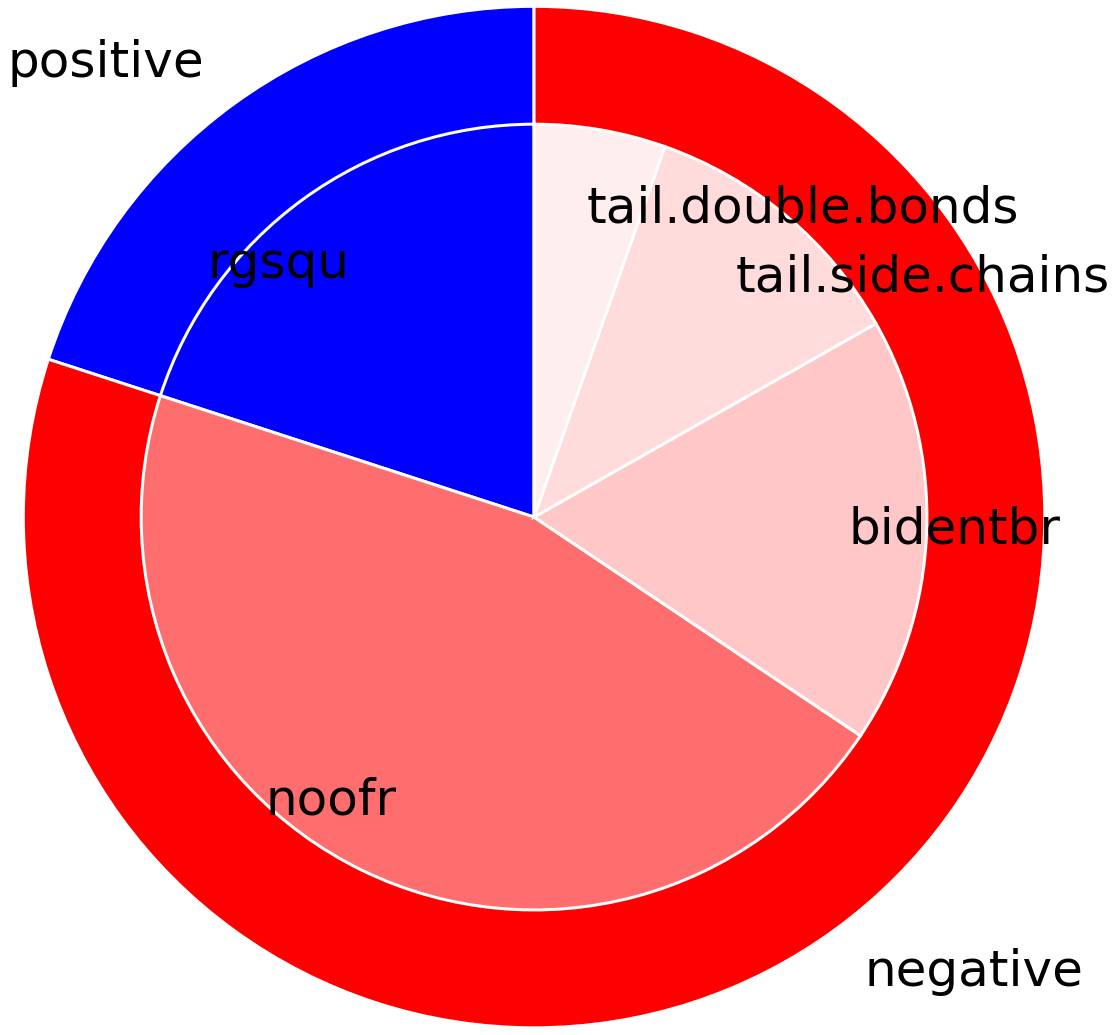

In [63]:
fpairs = {}
for i,f in enumerate(reserved_feats):
    fpairs.update({f:lfeatures[i]})
featuredict = fpairs
fpairs = sorted(fpairs.items(), key=lambda x: x[1])
featuredict1 = {}
for i,f in enumerate(reserved_feats):
    featuredict1.update({fpairs[i][0]:fpairs[i][1]})

plot_LASSO_pie(featuredict1,0.001)
plt.savefig('eln_coef_pie'+str(temp)+'-'+str(sp)+'ms'+cov+'.svg', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=False, bbox_inches='tight', pad_inches=0.1,
        frameon=None, metadata=None)

In [61]:
featuredict1

{'noofr': -0.011142853198533205,
 'bidentbr': -0.0042970622950379445,
 'tail.side.chains': -0.0027860484131799817,
 'tail.double.bonds': -0.0013193015152858016,
 'CO.double.bonds': -0.0006549177799430086,
 'num.atoms': -0.0003112799621617707,
 'num.heavy.atom': 0.00017574210338390712,
 'monodent': 0.0007457461911136914,
 'rgsqu': 0.0011976384390454062}

In [ ]:
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=5, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 0.3])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')

# Show estimated coef_ vs true coef
plt.subplot(2, 1, 2)
plt.plot(labels, label='True coef',linewidth=5)
plt.plot(coef, label='Estimated coef',marker='o',linestyle='None',markerfacecolor='red',markersize=8)
plt.legend()
plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.26)
#plt.show()
plt.savefig('eln-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.png', dpi=None, facecolor='w', edgecolor='w',
#plt.savefig('test.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [ ]:
#Show estimated coef_ vs true coef
plt.rc('font', size=30) 
plt.rcParams["figure.figsize"] = (20,6) 
plt.plot(labels, label='NEMD COF',linewidth=5) 
plt.plot(coef, label='Estimated COF',marker='o',linestyle='None',markerfacecolor='red',markersize=10)
plt.ylabel('COFs'); plt.xlabel('OFRs'); #axs.title('Variable Importances');
plt.xticks([])
plt.legend() 
plt.tight_layout()
plt.savefig('cof-overlay-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [ ]:
from scipy.stats import spearmanr
score, test_p = spearmanr(labels,coef)

In [ ]:
score,test_p